In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="2eOZiaYbTKlrmCqasL69")
project = rf.workspace("yssp").project("field-xzc0o")
version = project.version(6)
dataset = version.download("yolov8")
                

loading Roboflow workspace...
loading Roboflow project...


In [6]:
import os
import yaml
import cv2
import matplotlib.pyplot as plt
import numpy as np

# データセットのパス
dataset_path = "./field.v6i.yolov8"

# data.yamlを読み込み
with open(os.path.join(dataset_path, "data.yaml"), 'r') as f:
    data_config = yaml.safe_load(f)

print("=== データセット情報 ===")
print(f"クラス数: {data_config['nc']}")
print(f"クラス名: {data_config['names']}")

# 各セットの画像数を確認
for split in ['train', 'valid', 'test']:
    img_dir = os.path.join(dataset_path, split, 'images')
    if os.path.exists(img_dir):
        count = len(os.listdir(img_dir))
        print(f"{split}セット: {count}枚")

=== データセット情報 ===
クラス数: 7
クラス名: ['18Yard', '18Yard Circle', '5Yard', 'First Half Central Circle', 'First Half Field', 'Second Half Central Circle', 'Second Half Field']
trainセット: 2523枚
validセット: 161枚
testセット: 101枚



=== クラスID対応表 ===
ID 0: 18Yard
ID 1: 18Yard Circle
ID 2: 5Yard
ID 3: First Half Central Circle
ID 4: First Half Field
ID 5: Second Half Central Circle
ID 6: Second Half Field


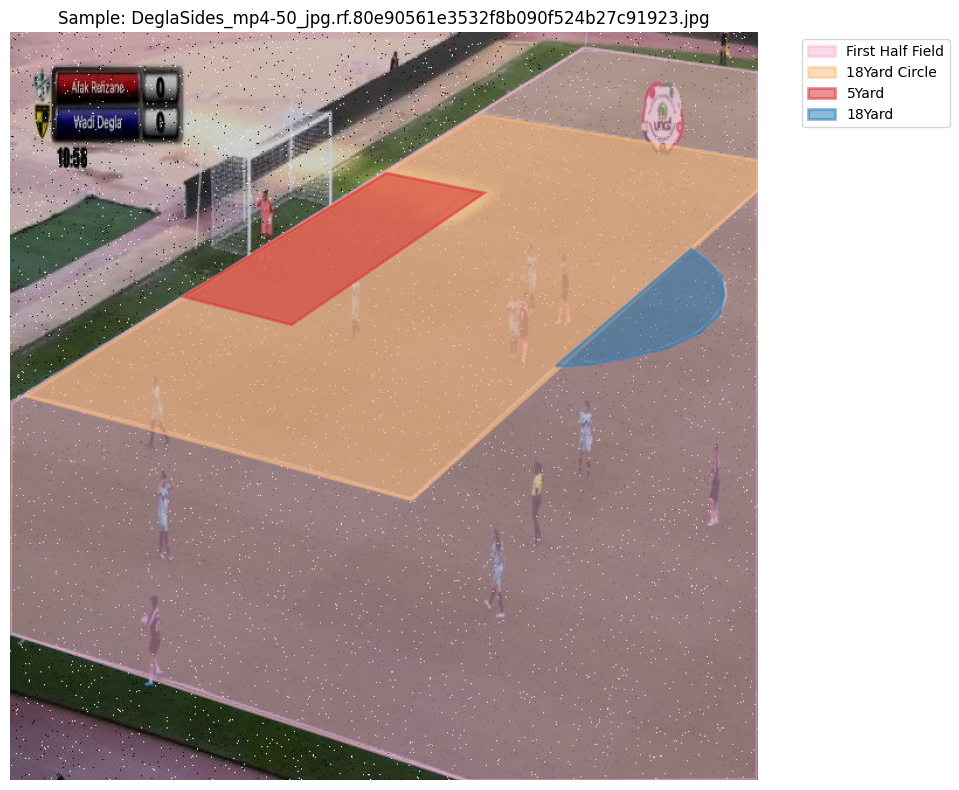

In [7]:
# クラスIDと名前の対応を表示
print("\n=== クラスID対応表 ===")
for idx, name in enumerate(data_config['names']):
    print(f"ID {idx}: {name}")

# サンプル画像とアノテーションを確認
train_images = os.listdir(os.path.join(dataset_path, 'train', 'images'))
sample_image_name = train_images[0]

# 画像を読み込み
img_path = os.path.join(dataset_path, 'train', 'images', sample_image_name)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ラベルファイルを読み込み
label_name = sample_image_name.replace('.jpg', '.txt').replace('.png', '.txt')
label_path = os.path.join(dataset_path, 'train', 'labels', label_name)

# 可視化
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img_rgb)

# セグメンテーションマスクを描画
colors = plt.cm.tab20(np.linspace(0, 1, len(data_config['names'])))

with open(label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        class_id = int(parts[0])
        
        # ポリゴン座標（正規化されている）
        coords = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)
        
        # 画像サイズに合わせてスケール
        h, w = img.shape[:2]
        coords[:, 0] *= w
        coords[:, 1] *= h
        
        # ポリゴンを描画
        from matplotlib.patches import Polygon
        poly = Polygon(coords, alpha=0.5, 
                      facecolor=colors[class_id],
                      edgecolor=colors[class_id],
                      linewidth=2,
                      label=f"{data_config['names'][class_id]}")
        ax.add_patch(poly)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(f"Sample: {sample_image_name}")
ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# 全ラベルファイルからクラス分布を集計
from collections import Counter

class_counts = Counter()
total_polygons = 0

label_dir = os.path.join(dataset_path, 'train', 'labels')
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
                    total_polygons += 1

print(f"\n=== クラス分布（訓練セット）===")
print(f"総ポリゴン数: {total_polygons}")
for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    class_name = data_config['names'][class_id]
    percentage = (count / total_polygons) * 100
    print(f"{class_id}: {class_name:<30} {count:>6}個 ({percentage:>5.1f}%)")


=== クラス分布（訓練セット）===
総ポリゴン数: 11117
0: 18Yard                           1941個 ( 17.5%)
1: 18Yard Circle                    1834個 ( 16.5%)
2: 5Yard                            1484個 ( 13.3%)
3: First Half Central Circle        1158個 ( 10.4%)
4: First Half Field                 1797個 ( 16.2%)
5: Second Half Central Circle       1195個 ( 10.7%)
6: Second Half Field                1708個 ( 15.4%)


In [9]:
import torch
import platform

print("=== システム情報 ===")
print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")
print(f"MPS利用可能: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

if torch.backends.mps.is_available():
    print("\n✅ MPSが利用可能です！")
    # テスト
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(f"MPSテスト成功: {x}")
else:
    print("\n❌ MPSが利用できません")

=== システム情報 ===
Python version: 3.11.13
PyTorch version: 2.7.1
MPS利用可能: True
MPS built: True

✅ MPSが利用可能です！
MPSテスト成功: tensor([1.], device='mps:0')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/rn/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Apple Silicon GPU (MPS) を使用します
💾 ユニファイドメモリ: 64GB
現在のMPSメモリ使用量: 0.00 GB
📝 Phase 1: Nano モデルで基礎学習
自動設定されたバッチサイズ: 32

=== YOLOv8n-seg 高性能学習 ===
モデルサイズ: n
画像サイズ: 640
バッチサイズ: 32
エポック数: 30
キャッシュ: ram



🚀 学習を開始します...
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.7.1 MPS (Apple M4 Max)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=field_data_64gb.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=field_seg_64gb_n_20250802_214746, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, 

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /Users/rn/Documents/FC/Text2Field/field.v6i.yolov8/train/labels... 2523 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2523/2523 [00:00<00:00, 4698.15it/s]

train: New cache created: /Users/rn/Documents/FC/Text2Field/field.v6i.yolov8/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.9GB RAM): 100%|██████████| 2523/2523 [00:00<00:00, 3436.74it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4871.2±1643.6 MB/s, size: 129.0 KB)



val: Scanning /Users/rn/Documents/FC/Text2Field/field.v6i.yolov8/valid/labels... 161 images, 0 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 4438.71it/s]

val: New cache created: /Users/rn/Documents/FC/Text2Field/field.v6i.yolov8/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 161/161 [00:00<00:00, 2870.54it/s]


Plotting labels to runs/segment/field_seg_64gb_n_20250802_214746/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/field_seg_64gb_n_20250802_214746
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       1/30      10.5G       0.83       1.61      1.721      1.133        310        640: 100%|██████████| 79/79 [03:10<00:00,  2.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:18<00:36, 18.33s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:27<00:13, 13.17s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:38<00:00, 12.97s/it]

                   all        161        705      0.421      0.115     0.0578     0.0286      0.337     0.0479      0.017    0.00602



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       2/30      10.5G     0.7913      1.205      1.215      1.094        262        640: 100%|██████████| 79/79 [02:33<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:11<00:22, 11.27s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:23<00:12, 12.06s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:31<00:00, 10.52s/it]

                   all        161        705      0.432      0.299      0.217      0.147      0.422      0.245      0.178      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       3/30      10.5G     0.7079       1.03      1.082      1.052        284        640: 100%|██████████| 79/79 [02:51<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:14<00:28, 14.14s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:28<00:14, 14.10s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:35<00:00, 11.75s/it]

                   all        161        705      0.399      0.215      0.146     0.0953      0.391      0.207      0.141     0.0977



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       4/30      10.5G     0.6635     0.9715       1.02      1.025        263        640: 100%|██████████| 79/79 [02:49<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:16<00:33, 16.65s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:34<00:17, 17.18s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:45<00:00, 15.10s/it]

                   all        161        705      0.407       0.21      0.172      0.132      0.411      0.208       0.17      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       5/30      10.6G     0.6118     0.8572     0.9543     0.9976        273        640: 100%|██████████| 79/79 [03:00<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:16<00:32, 16.44s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:33<00:16, 16.60s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:43<00:00, 14.54s/it]

                   all        161        705      0.582      0.264      0.234      0.196       0.58      0.261      0.232      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       6/30      10.6G     0.5748      0.797     0.9096     0.9807        274        640: 100%|██████████| 79/79 [03:25<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:15<00:31, 15.87s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:29<00:14, 14.35s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.61s/it]

                   all        161        705      0.572      0.192      0.181       0.16      0.554      0.187      0.174      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       7/30      10.5G     0.5403     0.7552     0.8768     0.9648        242        640: 100%|██████████| 79/79 [03:37<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:16<00:33, 16.61s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:32<00:16, 16.16s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:46<00:00, 15.41s/it]

                   all        161        705       0.59      0.204      0.187      0.165      0.588      0.203      0.184      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       8/30      10.6G     0.5236     0.7233     0.8542     0.9561        304        640: 100%|██████████| 79/79 [03:27<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:15<00:31, 15.84s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:36<00:18, 18.73s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:47<00:00, 15.96s/it]

                   all        161        705      0.601      0.195       0.16      0.144      0.589      0.193      0.159      0.135



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
       9/30      10.5G     0.5072     0.6814     0.8338     0.9514        241        640: 100%|██████████| 79/79 [03:27<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:17<00:34, 17.23s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:34<00:17, 17.24s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:45<00:00, 15.01s/it]

                   all        161        705      0.651      0.265       0.25      0.225      0.646      0.262      0.247      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      10/30      10.6G     0.4827     0.6522     0.8072     0.9375        274        640: 100%|██████████| 79/79 [03:29<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:17<00:35, 17.90s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:30<00:14, 14.71s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.02s/it]

                   all        161        705      0.673      0.298      0.259      0.232      0.658      0.293      0.255      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      11/30      10.5G     0.4617     0.6237     0.7871     0.9287        279        640: 100%|██████████| 79/79 [03:33<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:17<00:34, 17.24s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:28<00:13, 13.92s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:45<00:00, 15.14s/it]

                   all        161        705       0.63      0.463      0.365      0.333      0.622      0.455      0.359      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      12/30      10.6G      0.445     0.5976     0.7775      0.923        297        640: 100%|██████████| 79/79 [03:35<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:14<00:28, 14.04s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:32<00:16, 16.48s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.07s/it]

                   all        161        705      0.696      0.287      0.248      0.229      0.684      0.282      0.244      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      13/30      10.6G     0.4359     0.5948     0.7629     0.9183        277        640: 100%|██████████| 79/79 [03:43<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:15<00:30, 15.08s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:33<00:16, 16.86s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:44<00:00, 14.87s/it]

                   all        161        705      0.686      0.541       0.43      0.387      0.676      0.535      0.424      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      14/30      10.6G     0.4242     0.5755     0.7495     0.9178        284        640: 100%|██████████| 79/79 [03:33<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:19<00:39, 19.77s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:44<00:22, 22.79s/it]

WARNING ⚠️ NMS time limit 3.650s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:00<00:00, 20.12s/it]

                   all        161        705      0.589      0.533      0.427      0.398      0.578      0.523      0.419      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      15/30      10.5G     0.4101     0.5467     0.7327     0.9089        265        640: 100%|██████████| 79/79 [03:35<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.23s/it]

                   all        161        705      0.687      0.913      0.732      0.678      0.682      0.905      0.726      0.652



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      16/30      10.3G     0.4053     0.5509     0.7256     0.9086        235        640: 100%|██████████| 79/79 [03:51<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:53<00:00, 17.83s/it]

                   all        161        705       0.67      0.946      0.781      0.726      0.681      0.923      0.779      0.703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      17/30      10.4G      0.399     0.5312     0.7139     0.9033        256        640: 100%|██████████| 79/79 [04:07<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:39<00:00, 13.18s/it]

                   all        161        705       0.71      0.939      0.782      0.727      0.702      0.933      0.776      0.718



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      18/30      10.3G     0.3872     0.5124     0.6991     0.9005        313        640: 100%|██████████| 79/79 [04:24<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:51<00:00, 17.13s/it]

                   all        161        705      0.702      0.766      0.679      0.643      0.696       0.76      0.671      0.622



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      19/30      10.3G      0.378     0.5009      0.685     0.8972        259        640: 100%|██████████| 79/79 [04:05<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.81s/it]

                   all        161        705      0.704      0.935      0.799      0.755      0.702      0.929      0.796      0.732



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      20/30      10.3G     0.3729     0.5024     0.6764     0.8963        279        640: 100%|██████████| 79/79 [04:09<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.25s/it]

                   all        161        705      0.679      0.936      0.747      0.703      0.672      0.927      0.741       0.68


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      21/30      9.32G     0.3794     0.4195     0.6389     0.9031        108        640: 100%|██████████| 79/79 [07:06<00:00,  5.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.01s/it]

                   all        161        705        0.7      0.953      0.747      0.692      0.695      0.945      0.743      0.676



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      22/30      9.43G     0.3684     0.4067     0.6107     0.8924        109        640: 100%|██████████| 79/79 [05:57<00:00,  4.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.09s/it]

                   all        161        705      0.697      0.951      0.782       0.74      0.702       0.92      0.776      0.723



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      23/30      9.41G      0.358     0.4052     0.5949     0.8885        117        640: 100%|██████████| 79/79 [05:53<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.79s/it]

                   all        161        705      0.702      0.962      0.767       0.73      0.698      0.949      0.762      0.702



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      24/30      9.44G     0.3468     0.3919     0.5808     0.8825        106        640: 100%|██████████| 79/79 [05:26<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.91s/it]

                   all        161        705      0.699      0.966      0.786      0.744       0.69      0.951      0.781      0.724



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      25/30      9.41G     0.3304     0.3773     0.5561     0.8727        109        640: 100%|██████████| 79/79 [04:51<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]

                   all        161        705       0.69      0.954      0.784      0.747      0.682      0.952       0.78      0.722



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      26/30      9.53G     0.3271     0.3824     0.5413     0.8745        110        640: 100%|██████████| 79/79 [04:26<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.43s/it]

                   all        161        705      0.729      0.951      0.848      0.813      0.723      0.944      0.843       0.79



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      27/30      9.29G     0.3056     0.3636     0.5105     0.8654        112        640: 100%|██████████| 79/79 [04:22<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.54s/it]

                   all        161        705      0.708      0.928      0.808      0.777      0.701       0.92      0.803      0.747



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      28/30       9.4G     0.2983     0.3686     0.4961     0.8601        112        640: 100%|██████████| 79/79 [04:20<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.59s/it]

                   all        161        705       0.79      0.926      0.895      0.866      0.783      0.919      0.891      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      29/30      9.43G     0.2896      0.354     0.4744     0.8568        114        640: 100%|██████████| 79/79 [04:31<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.56s/it]

                   all        161        705      0.807      0.899      0.901      0.873      0.793      0.906      0.896      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]divide by zero encountered in matmul
overflow encountered in matmul
invalid value encountered in matmul
      30/30      9.58G     0.2764     0.3363      0.448     0.8578        106        640: 100%|██████████| 79/79 [04:13<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.72s/it]

                   all        161        705      0.781       0.94      0.898      0.872      0.774      0.933      0.893      0.837



30 epochs completed in 2.310 hours.
Optimizer stripped from runs/segment/field_seg_64gb_n_20250802_214746/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/field_seg_64gb_n_20250802_214746/weights/best.pt, 6.8MB

Validating runs/segment/field_seg_64gb_n_20250802_214746/weights/best.pt...
Ultralytics 8.3.173 🚀 Python-3.11.13 torch-2.7.1 MPS (Apple M4 Max)
YOLOv8n-seg summary (fused): 85 layers, 3,259,429 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:01<00:00, 20.63s/it]


                   all        161        705      0.806      0.901      0.901      0.873      0.793      0.906      0.896      0.837
                18Yard        137        138      0.993      0.979      0.994      0.962      0.954      0.964      0.983      0.929
         18Yard Circle        125        126      0.997      0.992      0.995      0.924      0.989      0.984      0.993      0.875
                 5Yard        106        107          1      0.967      0.991      0.933       0.99      0.958      0.984      0.871
First Half Central Circle         63         64      0.662      0.875      0.854      0.846      0.638      0.906      0.854      0.823
      First Half Field        113        113      0.672      0.858      0.821      0.816      0.668      0.871      0.821      0.811
Second Half Central Circle         55         56      0.682      0.881      0.846      0.838      0.685      0.911      0.846      0.786
     Second Half Field        100        101      0.638      0

KeyError: 'train/lr0'

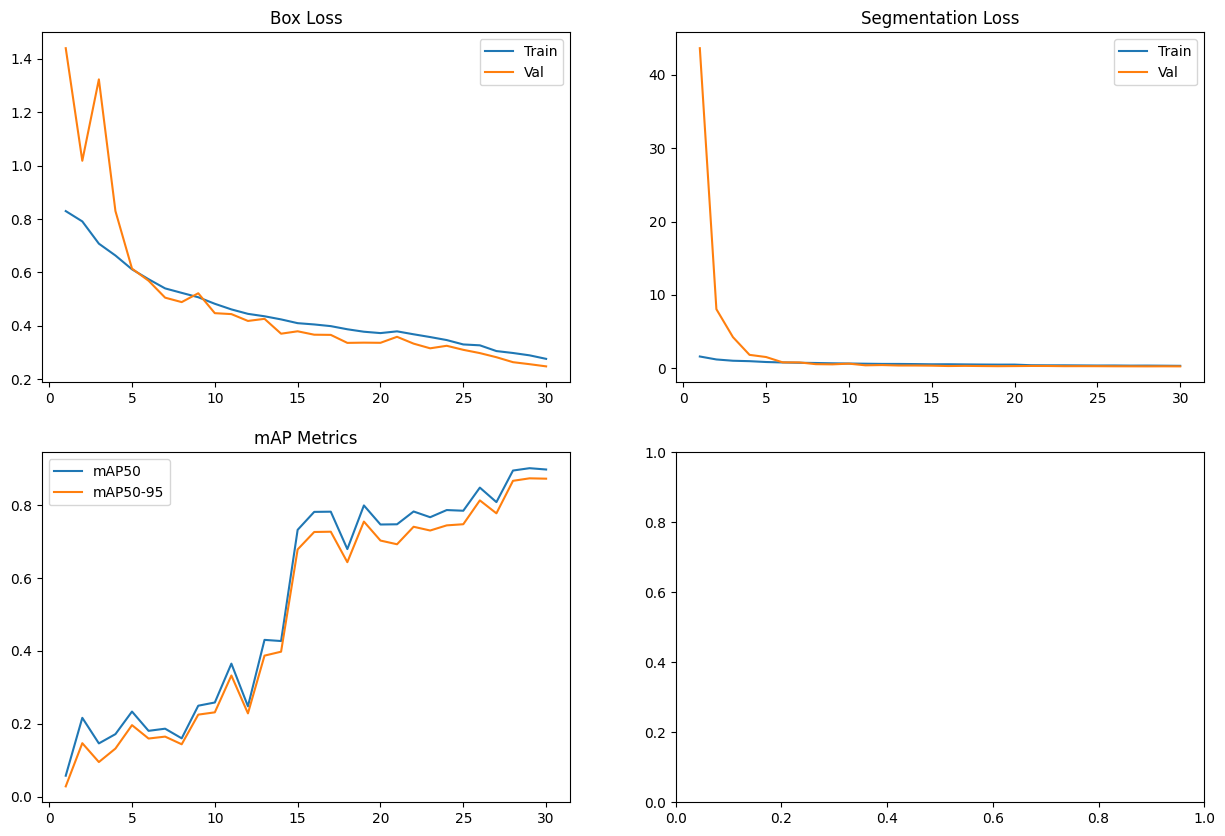

: 

In [ ]:
import os
import yaml
import torch
from ultralytics import YOLO
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

class YOLOv8MPSTrainer64GB:
    """64GB ユニファイドメモリ Mac用の最適化されたYOLOv8学習"""
    
    def __init__(self, dataset_path: str):
        self.dataset_path = os.path.abspath(dataset_path)
        self.device = self._setup_device()
        self.data_config = self._prepare_data_config()
        
        # 64GB用の環境変数設定
        os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        
    def _setup_device(self):
        """デバイスの設定と情報表示"""
        if torch.backends.mps.is_available():
            device = 'mps'
            print("✅ Apple Silicon GPU (MPS) を使用します")
            print("💾 ユニファイドメモリ: 64GB")
            
            # メモリ使用状況を確認
            if hasattr(torch.mps, 'current_allocated_memory'):
                print(f"現在のMPSメモリ使用量: {torch.mps.current_allocated_memory() / 1e9:.2f} GB")
        else:
            device = 'cpu'
            print("⚠️ MPSが利用できないため、CPUを使用します")
        return device
    
    def _prepare_data_config(self):
        """データ設定の準備"""
        with open(os.path.join(self.dataset_path, "data.yaml"), 'r') as f:
            data_config = yaml.safe_load(f)
        
        data_config['path'] = self.dataset_path
        
        temp_yaml_path = 'field_data_64gb.yaml'
        with open(temp_yaml_path, 'w') as f:
            yaml.dump(data_config, f)
        
        return temp_yaml_path
    
    def get_optimal_batch_size(self, model_size='m', imgsz=640):
        """64GBメモリに最適なバッチサイズを推定"""
        # モデルサイズとメモリ使用量の関係（経験則）
        batch_size_map = {
            'n': {'320': 64, '416': 48, '640': 32, '800': 24, '1280': 12},
            's': {'320': 48, '416': 36, '640': 24, '800': 16, '1280': 8},
            'm': {'320': 32, '416': 24, '640': 16, '800': 12, '1280': 6},
            'l': {'320': 24, '416': 16, '640': 12, '800': 8, '1280': 4},
            'x': {'320': 16, '416': 12, '640': 8, '800': 6, '1280': 3},
        }
        
        imgsz_str = str(imgsz)
        if imgsz_str not in batch_size_map[model_size]:
            # 最も近いサイズを選択
            sizes = list(map(int, batch_size_map[model_size].keys()))
            closest = min(sizes, key=lambda x: abs(x - imgsz))
            imgsz_str = str(closest)
        
        return batch_size_map[model_size][imgsz_str]
    
    def train_high_performance(self, 
                              model_size='m',    # 64GBならmediumモデルも快適
                              epochs=100,        # より多くのエポックも可能
                              imgsz=640,
                              auto_batch=True,   # 自動バッチサイズ調整
                              cache='ram',       # RAMにデータセットをキャッシュ
                              multi_scale=True,  # マルチスケール学習
                              patience=20):
        """高性能学習の実行"""
        
        # 最適なバッチサイズを自動設定
        if auto_batch:
            batch_size = self.get_optimal_batch_size(model_size, imgsz)
            print(f"自動設定されたバッチサイズ: {batch_size}")
        else:
            batch_size = 16  # デフォルト
        
        print(f"\n=== YOLOv8{model_size}-seg 高性能学習 ===")
        print(f"モデルサイズ: {model_size}")
        print(f"画像サイズ: {imgsz}")
        print(f"バッチサイズ: {batch_size}")
        print(f"エポック数: {epochs}")
        print(f"キャッシュ: {cache}")
        
        # モデル初期化
        model = YOLO(f'yolov8{model_size}-seg.pt')
        
        # 高性能学習パラメータ
        training_args = {
            'data': self.data_config,
            'epochs': epochs,
            'imgsz': imgsz,
            'batch': batch_size,
            'device': self.device,
            'patience': patience,
            'save': True,
            'project': 'runs/segment',
            'name': f'field_seg_64gb_{model_size}_{datetime.now().strftime("%Y%m%d_%H%M%S")}',
            'exist_ok': False,
            'pretrained': True,
            
            # 最適化設定
            'optimizer': 'AdamW',      # より良い収束
            'lr0': 0.01,              # 初期学習率
            'lrf': 0.01,              # 最終学習率係数
            'momentum': 0.937,         # SGD momentum/Adam beta1
            'weight_decay': 0.0005,    # 重み減衰
            
            # 64GB特有の設定
            'cache': cache,            # データセットをRAMにキャッシュ
            'workers': 8,              # データローダーワーカー数
            'amp': False,              # MPSではAMP無効
            
            # データ拡張
            'hsv_h': 0.015,           # HSV-Hue
            'hsv_s': 0.7,             # HSV-Saturation
            'hsv_v': 0.4,             # HSV-Value
            'degrees': 0.0,           # 回転
            'translate': 0.1,         # 移動
            'scale': 0.5,             # スケール
            'shear': 0.0,             # せん断
            'perspective': 0.0,       # 透視変換
            'flipud': 0.0,            # 上下反転
            'fliplr': 0.5,            # 左右反転
            'mosaic': 1.0,            # モザイク
            'mixup': 0.0,             # ミックスアップ
            'copy_paste': 0.0,        # コピーペースト
            
            # その他
            'verbose': True,
            'seed': 42,
            'deterministic': True,
            'single_cls': False,
            'rect': False,
            'cos_lr': False,          # コサイン学習率スケジューラ
            'close_mosaic': 10,       # 最後の10エポックでモザイク無効
            
            # マルチスケール学習
            'multi_scale': multi_scale,
        }
        
        # 学習実行
        print("\n🚀 学習を開始します...")
        results = model.train(**training_args)
        
        print("\n✅ 学習が完了しました！")
        
        # 結果の保存
        best_model_path = Path(results.save_dir) / 'weights' / 'best.pt'
        last_model_path = Path(results.save_dir) / 'weights' / 'last.pt'
        
        self._plot_training_results(results)
        
        return best_model_path, results
    
    def _plot_training_results(self, results):
        """学習結果の可視化"""
        # 学習曲線のプロット
        results_path = Path(results.save_dir) / 'results.csv'
        
        if results_path.exists():
            import pandas as pd
            df = pd.read_csv(results_path)
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Box loss
            axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train')
            axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val')
            axes[0, 0].set_title('Box Loss')
            axes[0, 0].legend()
            
            # Segmentation loss
            axes[0, 1].plot(df['epoch'], df['train/seg_loss'], label='Train')
            axes[0, 1].plot(df['epoch'], df['val/seg_loss'], label='Val')
            axes[0, 1].set_title('Segmentation Loss')
            axes[0, 1].legend()
            
            # mAP
            axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
            axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
            axes[1, 0].set_title('mAP Metrics')
            axes[1, 0].legend()
            
            # Learning rate
            axes[1, 1].plot(df['epoch'], df['train/lr0'], label='lr0')
            axes[1, 1].set_title('Learning Rate')
            axes[1, 1].set_yscale('log')
            
            plt.tight_layout()
            plt.savefig(Path(results.save_dir) / 'training_curves.png', dpi=300)
            plt.show()
    
    def benchmark_inference_speed(self, model_path: str, test_images_dir: str, num_images=10):
        """推論速度のベンチマーク"""
        import time
        
        model = YOLO(model_path)
        
        # テスト画像を取得
        test_images = list(Path(test_images_dir).glob('*.jpg'))[:num_images]
        
        # ウォームアップ
        for _ in range(3):
            _ = model(test_images[0], device=self.device, verbose=False)
        
        # ベンチマーク
        times = []
        for img_path in test_images:
            start = time.time()
            _ = model(img_path, device=self.device, verbose=False)
            times.append(time.time() - start)
        
        avg_time = np.mean(times) * 1000  # ms
        fps = 1000 / avg_time
        
        print(f"\n📊 推論速度ベンチマーク結果:")
        print(f"平均推論時間: {avg_time:.2f} ms/画像")
        print(f"FPS: {fps:.2f}")
        
        return avg_time, fps


# 実行スクリプト
if __name__ == "__main__":
    # 64GB最適化トレーナーを初期化
    trainer = YOLOv8MPSTrainer64GB(dataset_path="./field.v6i.yolov8")
    
    # プログレッシブ学習戦略
    # 1. まず小さいモデルで高速に学習
    print("📝 Phase 1: Nano モデルで基礎学習")
    nano_model, _ = trainer.train_high_performance(
        model_size='n',
        epochs=30,
        imgsz=640,
        multi_scale=False
    )
    
    # 2. 中規模モデルで本格学習
    print("\n📝 Phase 2: Medium モデルで本格学習")
    medium_model, _ = trainer.train_high_performance(
        model_size='m',
        epochs=100,
        imgsz=640,
        multi_scale=True
    )
    
    # 3. 大規模モデルで精度追求（オプション）
    print("\n📝 Phase 3: Large モデルで高精度学習")
    large_model, _ = trainer.train_high_performance(
        model_size='l',
        epochs=100,
        imgsz=800,  # より高解像度
        multi_scale=True
    )
    
    # ベンチマーク
    test_dir = "./field.v6i.yolov8/test/images"
    trainer.benchmark_inference_speed(medium_model, test_dir)

In [8]:
# 1. 最もシンプルな推論（Jupyter用）
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# モデルをロード（最新のモデルパスを指定）
model_path = "runs/segment/field_seg_64gb_n_20250802_214746/weights/best.pt"  # 実際のパスに変更
model = YOLO(model_path)

# 画像を推論
image_path = "sample2.png"  # 推論したい画像
results = model(image_path)

# 結果を表示
results[0].show()  # 別ウィンドウで表示


image 1/1 /Users/rn/Documents/FC/Text2Field/sample2.png: 384x640 2 First Half Central Circles, 2 First Half Fields, 28.7ms
Speed: 0.9ms preprocess, 28.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


🔍 自動検出: runs/segment/field_seg_64gb_n_20250802_214746/weights/best.pt
📦 モデルをロード中...
🖼️ 推論実行: sample1.png

image 1/1 /Users/rn/Documents/FC/Text2Field/sample1.png: 480x640 1 First Half Central Circle, 1 First Half Field, 1 Second Half Central Circle, 1 Second Half Field, 40.7ms
Speed: 1.5ms preprocess, 40.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
✅ 4個のオブジェクトを検出
   - Second Half Field: 1個
   - First Half Field: 1個
   - First Half Central Circle: 1個
   - Second Half Central Circle: 1個


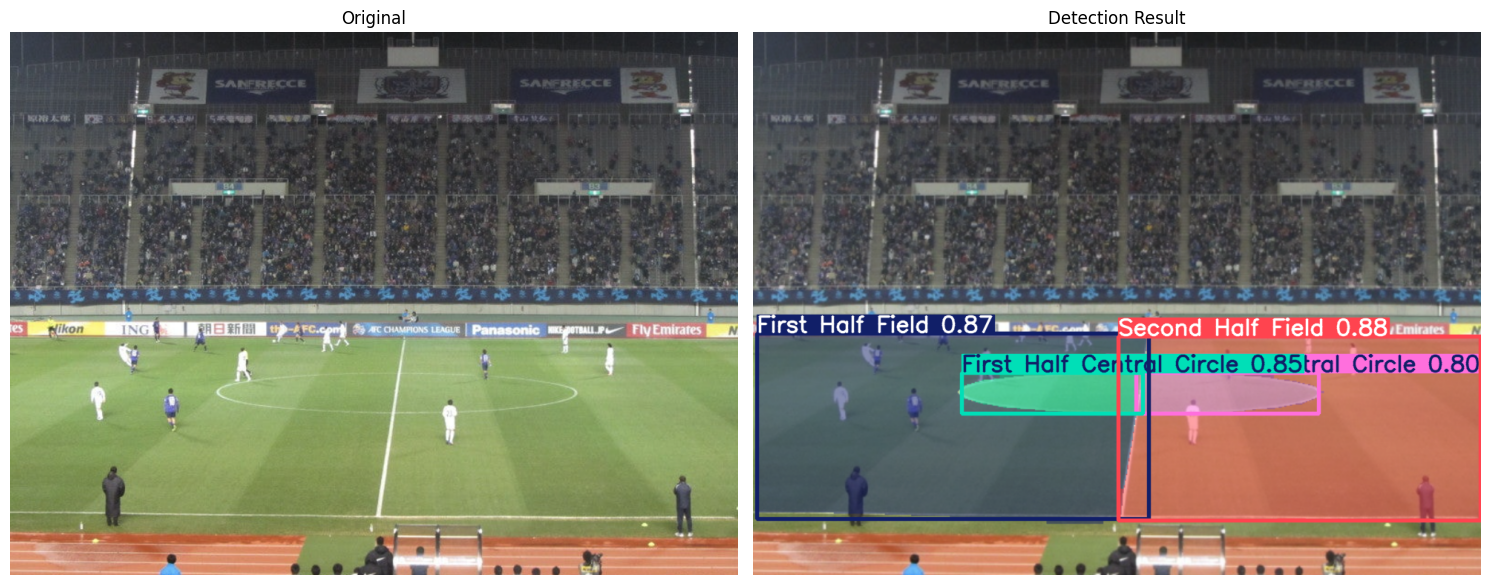

💾 結果を保存: result.jpg


In [9]:
def inference_jupyter(image_path, model_path=None):
    """Jupyter環境用の推論関数"""
    
    # モデルパスの自動検索
    if model_path is None:
        from pathlib import Path
        runs_dir = Path("runs/segment")
        if runs_dir.exists():
            # 最新のbest.ptを探す
            best_models = list(runs_dir.glob("*/weights/best.pt"))
            if best_models:
                model_path = str(max(best_models, key=lambda p: p.stat().st_mtime))
                print(f"🔍 自動検出: {model_path}")
            else:
                raise FileNotFoundError("学習済みモデルが見つかりません")
    
    # モデルロード
    print(f"📦 モデルをロード中...")
    model = YOLO(model_path)
    
    # 推論実行
    print(f"🖼️ 推論実行: {image_path}")
    results = model(image_path, conf=0.25)
    result = results[0]
    
    # 検出結果を表示
    if result.boxes is not None:
        print(f"✅ {len(result.boxes)}個のオブジェクトを検出")
        
        # クラスごとの集計
        class_counts = {}
        for box in result.boxes:
            class_name = model.names[int(box.cls)]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        for name, count in class_counts.items():
            print(f"   - {name}: {count}個")
    else:
        print("❌ 検出なし")
    
    # 結果を可視化
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # 元画像
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # アノテーション結果
    annotated = result.plot()
    axes[1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Detection Result")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 結果を保存
    cv2.imwrite("result.jpg", annotated)
    print("💾 結果を保存: result.jpg")
    
    return results

# 使用例
results = inference_jupyter("sample1.png")

In [10]:
import ipywidgets as widgets
from IPython.display import display

def interactive_inference():
    """インタラクティブな推論UI"""
    
    # ウィジェット作成
    file_upload = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='画像選択:'
    )
    
    conf_slider = widgets.FloatSlider(
        value=0.25,
        min=0.0,
        max=1.0,
        step=0.05,
        description='信頼度:',
        continuous_update=False
    )
    
    output = widgets.Output()
    
    def on_upload_change(change):
        """ファイルアップロード時の処理"""
        with output:
            output.clear_output()
            
            if file_upload.value:
                # アップロードされたファイルを取得
                uploaded = file_upload.value[0]
                
                # 一時ファイルとして保存
                with open('temp_upload.jpg', 'wb') as f:
                    f.write(uploaded['content'])
                
                # 推論実行
                results = inference_jupyter('temp_upload.jpg')
    
    # イベントハンドラを設定
    file_upload.observe(on_upload_change, names='value')
    conf_slider.observe(lambda x: on_upload_change(None), names='value')
    
    # UI表示
    display(widgets.VBox([file_upload, conf_slider, output]))

# 実行
interactive_inference()